In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

device = 'cuda:0'

Wed Jan 17 16:06:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Preprocess
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

# Create data loaders
# train_loader = DataLoader(mnist_trainset, batch_size=60000, shuffle=False)
# batch = next(iter(train_loader))
# data = preprocess(batch)
# print(data.keys())

test_loader = DataLoader(mnist_testset, batch_size=10000, shuffle=False)
batch = next(iter(test_loader))
data = preprocess(batch)
print(data.keys())

dict_keys(['x', 't'])


### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.init_log_sigma = 0

In [6]:
model_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
print('done')

done


### Load

In [7]:
from tqdm import tqdm_notebook as tqdm

save_path = '/data/scpark/save/lse/train01.16-6/save_200000'

# warm start
models_state_dict = torch.load(save_path, map_location=torch.device('cpu'))['models_state_dict']
for i, model in tqdm(enumerate(model_list)):
    model.load_state_dict(models_state_dict[i], strict=True)

0it [00:00, ?it/s]

### Reconstruction Loss

In [8]:
z_list = []
recon_loss_list = []
for model in tqdm(model_list):
    with torch.no_grad():
        data = model(data, M=1)
        z_list.append(data['z'])
        recon_loss_list.append(data['recon_loss'].item())
        
print('Reconstruction Loss :', np.mean(recon_loss_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Reconstruction Loss : 0.12490318045020103


### Get Real Standard Deviation

In [9]:
std_list = []
for z in z_list:
    std = (z.max(dim=0).values-z.min(dim=0).values)/2
    std_list.append(std)
    
print(std_list)

[tensor([0.9483, 0.9324], device='cuda:0'), tensor([0.9623, 0.9319], device='cuda:0'), tensor([0.9480, 0.9506], device='cuda:0'), tensor([0.9814, 0.9268], device='cuda:0'), tensor([0.9685, 0.9558], device='cuda:0'), tensor([0.9494, 0.9267], device='cuda:0'), tensor([0.9366, 0.9322], device='cuda:0'), tensor([0.9586, 0.9267], device='cuda:0'), tensor([0.9481, 0.9548], device='cuda:0'), tensor([0.9737, 0.9277], device='cuda:0')]


### MMD Test

In [10]:
from util.mmd_penalty import mmd_penalty

opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'normal', # 'normal', 'sphere', 'uniform' 
        'zdim': hp.z_dim
       }

mmd_losses = []
for z in tqdm(z_list):
    prior = model_list[0].prior.sample(len(z), hp.z_dim)
    mmd_loss = mmd_penalty(prior, z, opts)
    mmd_losses.append(mmd_loss.item())
    
print('MMD Loss :', np.mean(mmd_losses))    

  0%|          | 0/10 [00:00<?, ?it/s]

MMD Loss : 0.00020308494567871093


In [12]:
from util.mmd_penalty import mmd_penalty

opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'normal', # 'normal', 'sphere', 'uniform' 
        'zdim': hp.z_dim
       }

mmd_losses = []
for z, std in tqdm(zip(z_list, std_list)):
    prior = model_list[0].prior.sample(len(z), hp.z_dim) * std
    mmd_loss = mmd_penalty(prior, z, opts)
    mmd_losses.append(mmd_loss.item())
    
print('Corrected MMD Loss :', np.mean(mmd_losses))    

0it [00:00, ?it/s]

Corrected MMD Loss : 0.0007645845413208008


### Cross NLL Test

In [11]:
from util.loglikelihood import get_optimum_log_sigma, get_cross_nll

cross_nll_list = []
for _ in tqdm(range(10)):
    cross_nlls = []
    for z, model in zip(z_list, model_list):
        p_samples1 = model.prior.sample(len(z), hp.z_dim)
        p_samples2 = model.prior.sample(len(z), hp.z_dim)
        log_sigma = get_optimum_log_sigma(p_samples1, p_samples2, min_log_sigma=-5, max_log_sigma=5)
        p_samples1 = model.prior.sample(len(z), hp.z_dim)
        cross_nll = get_cross_nll(p_samples1, z, log_sigma)
        cross_nlls.append(cross_nll)
    cross_nll = np.mean(cross_nlls)
    cross_nll_list.append(cross_nll)
    
print('Cross NLL :', np.mean(cross_nll_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Cross NLL : -2.1486830139160156


In [13]:
from util.loglikelihood import get_optimum_log_sigma, get_cross_nll

cross_nll_list = []
for _ in tqdm(range(10)):
    cross_nlls = []
    for z, model, std in zip(z_list, model_list, std_list):
        p_samples1 = model.prior.sample(len(z), hp.z_dim) * std
        p_samples2 = model.prior.sample(len(z), hp.z_dim) * std
        log_sigma = get_optimum_log_sigma(p_samples1, p_samples2, min_log_sigma=-5, max_log_sigma=5)
        p_samples1 = model.prior.sample(len(z), hp.z_dim) * std
        cross_nll = get_cross_nll(p_samples1, z, log_sigma)
        cross_nlls.append(cross_nll)
    cross_nll = np.mean(cross_nlls)
    cross_nll_list.append(cross_nll)
    
print('Corrected Cross NLL :', np.mean(cross_nll_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Corrected Cross NLL : -2.1697227478027346


### View Embeddings

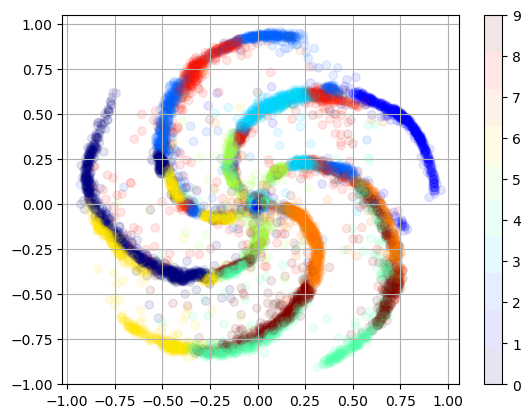

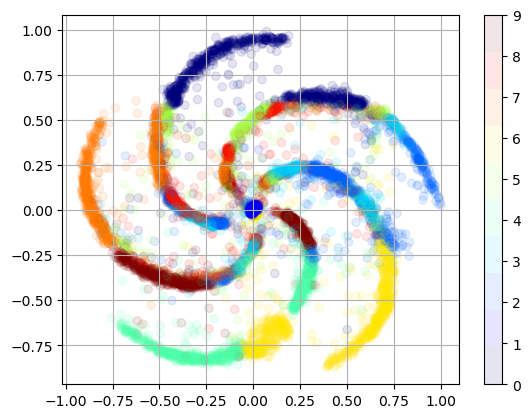

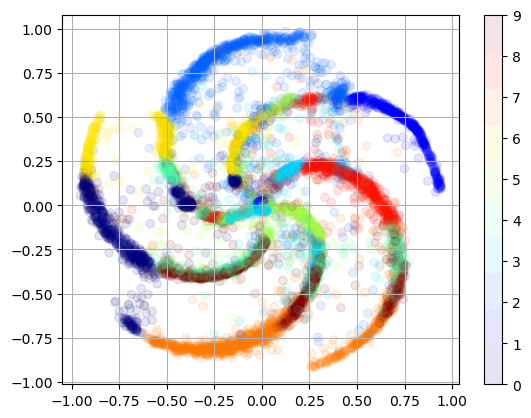

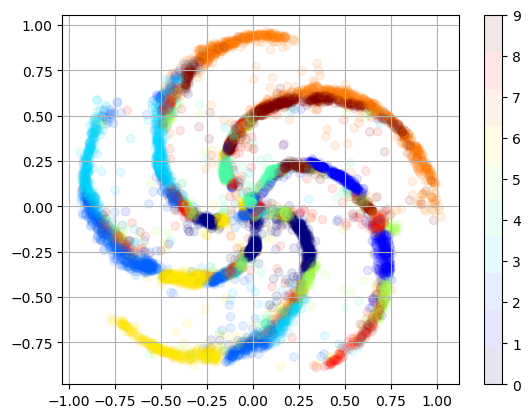

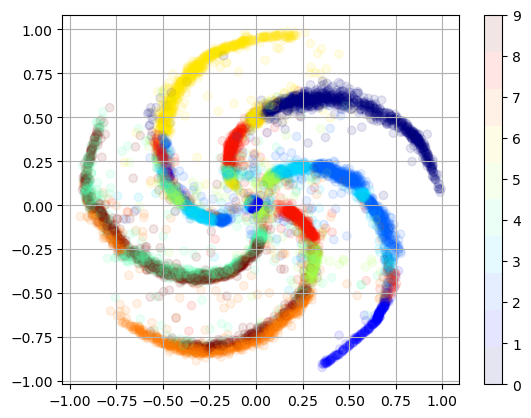

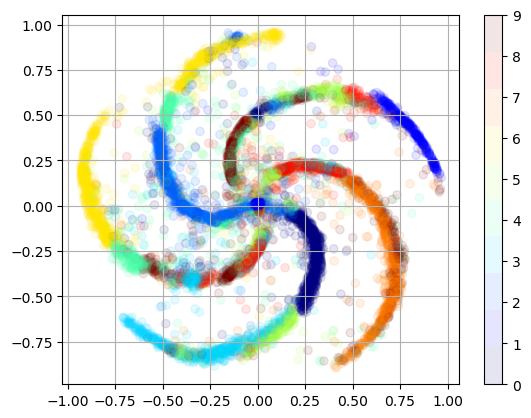

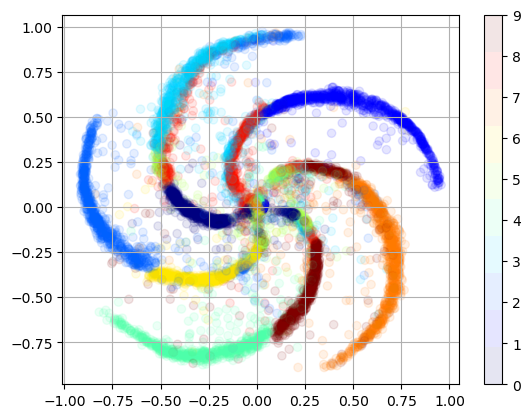

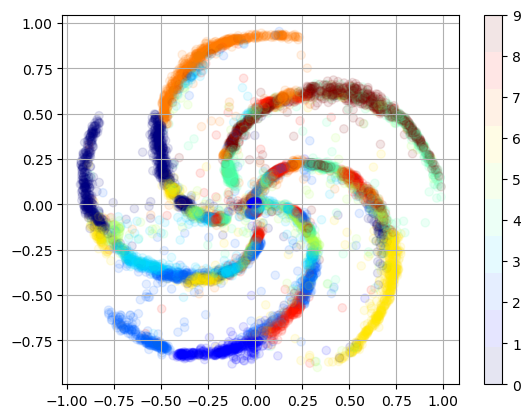

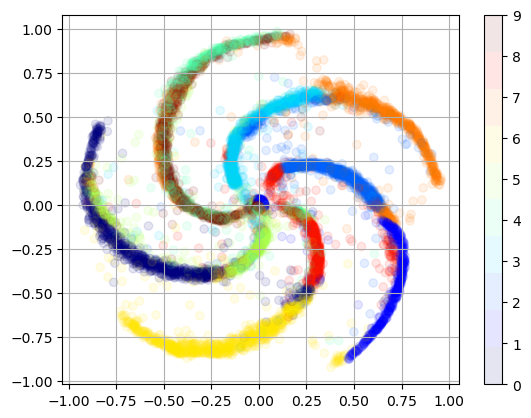

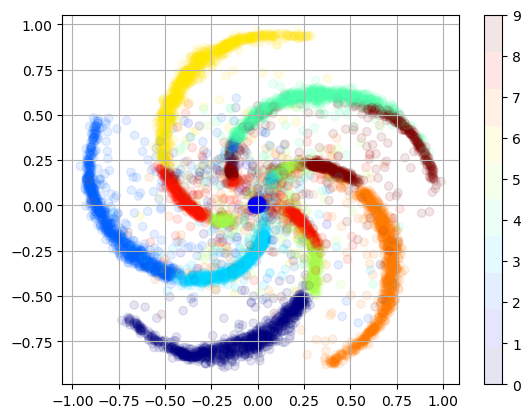

In [9]:
import matplotlib.pyplot as plt

# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


for z in z_list:
    _z = z.data.cpu().numpy()
    plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
    plt.grid()
    plt.colorbar()
    plt.show()